# Improvement Heuristics for the Traveling Salesman Problem in Python
As described [here](https://allaboutalgorithms.com/improvement-heuristics-for-the-traveling-salesman-problem-in-python-d89c07f218b2).

In [1]:
import math
import random

random.seed(123)

cities = [
    (
        random.random(),
        random.random(),
    )
    for _ in range(30)
]

distance_matrix = [
    [math.sqrt((start_city[0] - end_city[0]) ** 2 + (start_city[1] - end_city[1]) ** 2) for end_city in cities]
    for start_city in cities
]

In [2]:
# used for updating the length when swapping cities
# this allows us to recompute the length in O(1) instead of O(n)
def compute_costs_around_some_cities(
    distance_matrix,
    tour,
    indices,
):
    return sum(
        (distance_matrix[tour[index - 1]][tour[index]] + distance_matrix[tour[index]][tour[index + 1]] for index in indices)
    )


def swap_step(
    distance_matrix,
    initial_result,
):
    best_result = initial_result
    for j in range(
        1,
        len(initial_result["tour"]) - 1,
    ):
        for i in range(
            1,
            j,
        ):
            new_tour = initial_result["tour"].copy()

            # by swapping cities, four edges of the tour get destroyed, calculate their lengths
            lost_length = compute_costs_around_some_cities(
                distance_matrix,
                new_tour,
                (
                    i,
                    j,
                ),
            )

            # swap the cities
            (new_tour[i], new_tour[j],) = (
                new_tour[j],
                new_tour[i],
            )

            # by swapping cities, four edges of the tour get created, calculate their lengths
            added_length = compute_costs_around_some_cities(
                distance_matrix,
                new_tour,
                (
                    i,
                    j,
                ),
            )

            # like this, the length can be computed in constant time instead of O(n)
            new_length = initial_result["length"] - lost_length + added_length

            new_result = {
                "tour": new_tour,
                "length": new_length,
            }

            if new_result["length"] < best_result["length"]:
                best_result = new_result

    return best_result

In [3]:
def hill_climb(
    distance_matrix,
    initial_result,
    step_function,
    max_iter,
):
    best_result = initial_result
    counter = 0

    while True:
        new_result = step_function(
            distance_matrix,
            best_result,
        )
        counter += 1
        if new_result["length"] < best_result["length"] and counter <= max_iter:
            best_result = new_result
        else:
            return best_result

In [4]:
import matplotlib.pyplot as plt


def greedy_insert(
    distance_matrix,
    start,
):
    unvisited_cities = set(range(len(distance_matrix))) - {start}
    tour = [
        start,
        start,
    ]
    total_length = 0

    while unvisited_cities:
        (total_length, best_i, best_city,) = min(
            (
                (
                    total_length
                    - distance_matrix[tour[i - 1]][tour[i]]
                    + distance_matrix[tour[i - 1]][city]
                    + distance_matrix[city][tour[i]],
                    i,
                    city,
                )
                for city in unvisited_cities
                for i in range(
                    1,
                    len(tour),
                )
            ),
            key=lambda x: x[0],
        )
        tour = tour[:best_i] + [best_city] + tour[best_i:]
        unvisited_cities.remove(best_city)

    return {
        "tour": tour,
        "length": total_length,
    }


# again, we can optimize over the starting city
def greedy_insert_with_best_start(
    distance_matrix,
):
    return min(
        (
            greedy_insert(
                distance_matrix,
                start,
            )
            for start in range(len(distance_matrix))
        ),
        key=lambda x: x["length"],
    )


def plot(
    result,
    cities,
):
    plt.scatter(
        [city[0] for city in cities],
        [city[1] for city in cities],
    )

    plt.plot(
        [cities[result["tour"][i]][0] for i in range(len(result["tour"]))],
        [cities[result["tour"][i]][1] for i in range(len(result["tour"]))],
        c="k",
        linewidth=1,
        zorder=-1,
    )

    plt.title(f"Length = {result['length']:.2f}")

    plt.axis("off")

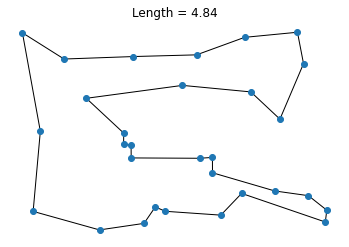

In [5]:
result = greedy_insert_with_best_start(distance_matrix)
improved_result = hill_climb(
    distance_matrix,
    result,
    swap_step,
    max_iter=100,
)

plot(
    improved_result,
    cities,
)

In [6]:
def two_opt_step(
    distance_matrix,
    initial_result,
):
    best_result = initial_result
    for j in range(
        1,
        len(initial_result["tour"]) - 1,
    ):
        for i in range(
            1,
            j - 1,
        ):
            start = initial_result["tour"][:i]
            middle = initial_result["tour"][i:j]
            end = initial_result["tour"][j:]
            new_result = {
                "tour": start + list(reversed(middle)) + end,
                "length": initial_result["length"]
                - distance_matrix[start[-1]][middle[0]]
                - distance_matrix[middle[-1]][
                    end[0]
                ]  # - sum((distance_matrix[middle[k]][middle[k+1]] for k in range(len(middle)-1))) \
                + distance_matrix[start[-1]][middle[-1]]
                + distance_matrix[middle[0]][
                    end[0]
                ],  # + sum((distance_matrix[middle[k+1]][middle[k]] for k in range(len(middle)-1)))
            }

            if new_result["length"] < best_result["length"]:
                best_result = new_result

    return best_result

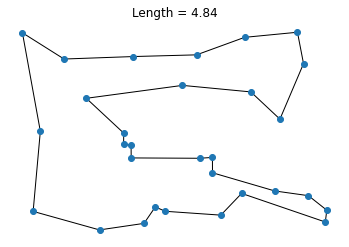

In [7]:
improved_result = hill_climb(
    distance_matrix,
    result,
    two_opt_step,
    max_iter=100,
)

plot(
    improved_result,
    cities,
)